<a href="https://colab.research.google.com/github/basusourya/mirostat/blob/master/Mirostat_sampling_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains experiments for Mirostat sampling, presented in ICLR 2021 ([paper](https://openreview.net/pdf?id=W1G1JZEIy5_))





In [ ]:
# tested with transformers version 4.16.2
!pip install transformers  

#### Math functions

In [2]:
# Theoretical function computations
import math

def H(k, s=1):
  result = 0
  for i in range(k):
    result += 1 / ((i + 1) ** s)
  return result

def U(k, s=1):
  return ((s * math.log(k + 1)) / (H(k + 1, s) * ((k + 1) ** s)) + math.log((H(k + 1, s)) / (H(k, s))))

def C(n, s):
  eps = s - 1
  return (1 - n ** (-eps)) / eps

def S_p(n, p, s, h_n):
  eps = s - 1
  b = 1 + 0.7 * eps
  result = (1 + eps) * h_n * p / (b * math.log(2)) - (1 + eps) * math.log2(b) / eps + math.log2(h_n)
  return result

def dS(n, p, s, h_n):
  eps = s - 1
  b = 1 + 0.7 * eps
  result = (1 + eps) * h_n * (1 + h_n * eps * p / b) / (b * math.log(2))
  return result

def H_X_k(k, s, h_n, bound='L'):
  "bound='L' means upperbound, 'U' means lowerbound"
  #h = H(k,s)
  eps = s - 1
  #h = (1+k**(-eps))/eps
  h = 0.7 + (1 - (k + 1) ** (-eps)) / eps
  #h = 1/(eps*(1+k**(-eps)))
  if s>1:
    a_1 = s*( math.log2(2)/(2**(s)) + (1/(math.log(2)*eps*(3**eps)))*(math.log(3)+1/eps) )
    a_2 = s/(math.log(2)*eps)
    b_1 = s*( math.log2(2)/(2**(s)) + math.log2(3)/(3**(s)) + (1/(math.log(2)*eps*(3**eps)))*(math.log(3)+1/eps) ) 
    b_2 = s/(math.log(2)*eps)
  if s==1:
    c_1 = (s/2)*(math.log2(2) - math.log2(3)*math.log2(3))
    c_2 = s/2
    d_1 = (s/2)*(math.log2(2) + 2*math.log2(3)/3 - math.log2(3)*math.log2(3))
    d_2 = s/2

  c = 1 + 0.7*eps
  result = (eps/c)*(b_1-(c*b_2*(math.log(k)+1/eps)-b_1)/(c*k**(eps)-1)) + math.log2(h_n)
  return result
  if s>1:
    if bound=='L':
      result = a_1/h - a_2/(h*((k+1)**eps))*(math.log(k+1) + 1/eps) + math.log2(h_n)
    elif bound=='U':
      result = b_1/h - b_2/(h*((k)**eps))*(math.log(k) + 1/eps) + math.log2(h_n)
  elif s==1:
    if bound=='L':
      result = c_1/h + c_2*math.log2(k+1)*math.log2(k+1)/h + math.log2(h_n)
    elif bound=='U':
      result = d_1/h + d_2*math.log2(k)*math.log2(k)/h + math.log2(h_n)

  return result

def H_X_k_actual(k,s,h_n):
  "bound='L' means upperbound, 'U' means lowerbound"
  result = 0
  h_k = H(k,s)
  for i in range(k):
    p_k = 1/(h_k*(i+1)**s)
    p_n = 1/(h_n*(i+1)**s)
    result += -p_k*math.log2(p_n)
  return result

def H_X_k_approx(k,s,h_n):
  eps = s-1
  result = (1-eps*math.log(k+1)/((k+1)**eps))/(eps*math.log(2)) + math.log(h_n)
  return result

def H_X_p(p,s,h_n):
  eps = s-1
  b_3 = 1+ 0.7*eps
  b_1 = s*( math.log2(2)/(2**(s)) + math.log2(3)/(3**(s)) + (1/(math.log(2)*eps*(3**eps)))*(math.log(3)+1/eps) ) 
  b_2 = s/(math.log(2)*eps)
  #result = b_2*eps*p*h_n + (b_1 - b_2/eps)/(p*h_n) + math.log2(h_n)
  #result = s*p*h_n/(2*math.log(2)) + s*eps*(p**2)*(h_n**2)/(2*math.log(2)) + math.log2(h_n)
  result = s*(p*h_n + eps*p**2*h_n**2)/(2*math.log(2)) + math.log2(h_n)
  return result

def H_X_p_actual(p,s,h_n):
  b_1 = s*( math.log2(2)/(2**(s)) + math.log2(3)/(3**(s)) + (1/(math.log(2)*eps*(3**eps)))*(math.log(3)+1/eps) ) 
  b_2 = s/(math.log(2)*eps)
  result = b_2*eps*p*h_n + (b_1 - b_2/eps)/(p*h_n) + math.log2(h_n)
  return result

def mu(n, eps_0=0.1):
  result = (1-(1+eps_0)*(n**(-eps_0)))/(math.log(n)) + (1-(n**(-eps_0)))/((math.log(n))**2)
  return result

def var_p(n, p, eps_0=0.1):
  result = (math.log(n)**2)*((1+eps_0/2)*mu(2*n,eps_0) - mu(n,eps_0)**2)
  return result

def var_k(n, k, eps_0=0.1):
  result = (eps_0**2)*(math.log(k)**2)/12 
  return result

def dif_k(n,k,e_1,e_2):
  result = (e_2-e_1)*(math.log(n/k))
  return result

def dif_p(n,p,e_1,e_2):
  result = (math.log(n))*(e_2-e_1 + p*((1+e_1)/(n**(e_1)) - (1+e_2)/(n**(e_2))))
  return result

def ent_p(p,h,s=1):
  if s==1:
    result = p*h/2 + (math.log(3)**2 - math.log(2))/(2*p*h) + math.log(p*h)
  elif s>1:
    result = p*h/2 + (s-1)*((p*h)**2)/2 + math.log(p*h)
  return result

def estimate_s(prob):
  result = 0
  num = 0
  den = 0
  for i in range(min(len(prob)-1,3000)):
    b = prob[i]/prob[i+1]
    t = (i+2)/(i+1)
    num += math.log(b)*math.log(t)
    den += math.log(t)**2
  return num/den

def compute_k(n,s,tau):
    eps = s-1
    k = ((eps*(2**(tau)))/(1-n**(-eps)))**(1/s)
    #print("k:",k, ";epsilon:",eps,";tau:",tau)
    k = round(k)
    return k
  
def rep_cost(tokens):
  "Takes list of tokens and returns repetition cost"
  cost = 0
  for i in range(len(tokens)-1):
    if tokens[i+1] in tokens[0:i+1]:
      cost += 1
  return cost**2

def rep_percentage(tokens):
  "Takes list of tokens and returns repetition cost"
  cost = 0
  for i in range(len(tokens)-1):
    if tokens[i+1] in tokens[0:i+1]:
      cost += 1
  return 100*cost/len(tokens)

def rep_percentage_n_gram(tokens,n=1):
  "Takes list of tokens and returns n-gram repetition cost"
  cost = 0
  tokens_n_gram = [tokens[i:i+n] for i in range(len(tokens)-n+1)]
  for i in range(len(tokens_n_gram)-1):
    if tokens_n_gram[i+1] in tokens_n_gram[0:i+1]:
      cost += 1
  return 100*cost/len(tokens_n_gram)

def sample_entropy(tokens):
  "takes tokens and computes its sample entropy"
  freq_dict = {tokens[0]:1}
  sample_entropy = 0
  for i in range(len(tokens)-1):
    if tokens[i+1] in tokens[0:i+1]:
      freq_dict.update({tokens[i+1]:freq_dict[tokens[i+1]]+1})
    else:
      freq_dict.update({tokens[i+1]:1})
  
  tot_freq = len(tokens)

  for i in freq_dict:
    p = freq_dict[i]/tot_freq
    sample_entropy += -p*math.log2(p) 
  return sample_entropy/len(tokens)

def expected_reps(k,m,s,h_n):
  "k: vocabulary size; m: number of tokens generated"
  distinct_tokens = 0
  h_k = H(k,s)
  for i in range(k):
    distinct_tokens += (1-(1-1/(h_k*(i+1)**s))**m)

  return (1-distinct_tokens/m)*100

###  5.1 CROSS-ENTROPY RATE FOR DIFFERENT SAMPLING METHOD

#### Text decoding for scatter plots

##### Top-k sampling

In [ ]:
k_list = []
for i in range(50):
  k_list.append((int(i/4)+1)*(int(i/4)+1)*3)
print(k_list)

In [8]:
# top-k decoding for scatter plot
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')
temperature = 1
num_tokens = 200
list_plot_surprise_k = []
gpt2_topk_rep_cost = []
gpt2_topk_ppl = []
gpt2_topk_ent = []

####################################################################
model.eval()

model.to('cuda')

indices_error_list = []
indices_surprise = []
running_tot_surprise = 0
list_avg_surprise = []

with torch.no_grad():

  for top_k in k_list:
    generated = tokenizer.encode("For two months early in 1943, Shannon came into contact with the leading British mathematician Alan Turing. Turing had been posted to Washington to share with the U.S. Navy's cryptanalytic service the methods used by the British Government Code and Cypher School at Bletchley Park to break the ciphers used by the Kriegsmarine U-boats in the north Atlantic Ocean. He was also interested in the encipherment of speech and to this end spent time at Bell Labs.")
    context = torch.tensor([generated])
    context = context.to('cuda')
    generated = []
    prev = context
    past = None
    indices_surprise = []
    indices_entropy = []
    for i in range(num_tokens):
      forward = model(input_ids=context, past_key_values=past, return_dict=True)
      logits = forward.logits[0,-1,:]
      past = forward.past_key_values
      sorted_logits, sorted_indices = torch.sort(logits, descending=True)
      prob_original = torch.softmax(sorted_logits, dim = 0)
      list_sorted_logits = sorted_logits.tolist()[0:top_k]
      prob_sorted = torch.softmax(torch.tensor(list_sorted_logits), dim = 0)
      prob_sorted_list = prob_sorted.tolist()
      prev_i = torch.multinomial(prob_sorted, num_samples=1, replacement=True)
      indices_surprise.append(math.log2(1/prob_original[prev_i]))
      indices_entropy.append(math.log2(1/prob_sorted[prev_i]))
      indices_error_list.append(prev_i)
      prev = sorted_indices[prev_i]
      running_tot_surprise += math.log2(1/prob_original[prev_i])
      list_avg_surprise.append(running_tot_surprise/(i+1))
      generated += prev.tolist()
      context = torch.tensor([prev.tolist()]).to('cuda')
    print("Total surprise value:", sum(indices_surprise))
    print("Average surprise value:", sum(indices_surprise)/num_tokens)
    #print(tokenizer.decode(generated))
    list_plot_surprise_k.append(sum(indices_surprise)/num_tokens)
    print("Repitition cost:",rep_cost(generated))
    gpt2_topk_rep_cost.append(rep_cost(generated))
    gpt2_topk_ppl.append(sum(indices_surprise)/num_tokens)
    gpt2_topk_ent.append(sum(indices_entropy)/num_tokens)

Total surprise value: 487.5170027141844
Average surprise value: 2.437585013570922
Repitition cost: 12100
Total surprise value: 372.4026294043991
Average surprise value: 1.8620131470219954
Repitition cost: 14161
Total surprise value: 468.77176427565604
Average surprise value: 2.34385882137828
Repitition cost: 13924
Total surprise value: 445.60526045027393
Average surprise value: 2.2280263022513696
Repitition cost: 13689
Total surprise value: 565.7871672194318
Average surprise value: 2.828935836097159
Repitition cost: 11025
Total surprise value: 546.4343302143252
Average surprise value: 2.732171651071626
Repitition cost: 9025
Total surprise value: 604.7839277607047
Average surprise value: 3.0239196388035237
Repitition cost: 7056
Total surprise value: 522.1362903062316
Average surprise value: 2.610681451531158
Repitition cost: 9801
Total surprise value: 570.9979858491636
Average surprise value: 2.854989929245818
Repitition cost: 11236
Total surprise value: 661.6476134152009
Average surpri

##### Top-p (nucleus) sampling

In [9]:
p_list = []
for i in range(32):
  p_list.append(int(10*(0.3 + int(i/4)*0.1))/10)
print(p_list)

[0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0]


In [12]:
#top-p decoding for scatter plot
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')
temperature = 1
top_p = 0.9
num_tokens = 200


list_plot_surprise_p = []
topp_rep_cost = []
topp_ppl = []
####################################################################

model.eval()

model.to('cuda')

indices_error_list = []
indices_surprise = []
running_tot_surprise = 0
list_avg_surprise = []

with torch.no_grad():

  for top_p in p_list:
    generated = tokenizer.encode("For two months early in 1943, Shannon came into contact with the leading British mathematician Alan Turing. Turing had been posted to Washington to share with the U.S. Navy's cryptanalytic service the methods used by the British Government Code and Cypher School at Bletchley Park to break the ciphers used by the Kriegsmarine U-boats in the north Atlantic Ocean. He was also interested in the encipherment of speech and to this end spent time at Bell Labs.")
    context = torch.tensor([generated])
    context = context.to('cuda')
    generated = []
    prev = context
    past = None
    indices_surprise = []

    for i in range(num_tokens):
      forward = model(input_ids=context, past_key_values=past, return_dict=True)
      logits = forward.logits[0,-1,:]
      past = forward.past_key_values
      sorted_logits, sorted_indices = torch.sort(logits, descending=True)
      prob_original = torch.softmax(sorted_logits, dim = 0)
      cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

      if sorted_indices[cumulative_probs <= top_p].size()[0]>0:
        sorted_indices = sorted_indices[cumulative_probs <= top_p]
        sorted_logits = sorted_logits[cumulative_probs <= top_p]
      else:
        sorted_indices = sorted_indices[0:1]
        sorted_logits = sorted_logits[0:1]

      prob_sorted = torch.softmax(sorted_logits, dim = 0)
      prob_sorted_list = prob_sorted.tolist()
      prev_i = torch.multinomial(prob_sorted, num_samples=1, replacement=True)
      indices_surprise.append(math.log2(1/prob_original[prev_i]))
      indices_error_list.append(prev_i)
      prev = sorted_indices[prev_i]
      running_tot_surprise += math.log2(1/prob_original[prev_i])
      list_avg_surprise.append(running_tot_surprise/(i+1))
      generated += prev.tolist()
      context = torch.tensor([prev.tolist()]).to('cuda')
    print("Total surprise value:", sum(indices_surprise))
    print("Average surprise value:", sum(indices_surprise)/num_tokens)
    #print(tokenizer.decode(generated))
    list_plot_surprise_p.append(sum(indices_surprise)/num_tokens)
    print("Repitition cost:",rep_cost(generated))
    topp_rep_cost.append(rep_cost(generated))
    topp_ppl.append(sum(indices_surprise)/num_tokens)

Total surprise value: 294.23046217439213
Average surprise value: 1.4711523108719606
Repitition cost: 16384
Total surprise value: 204.30972293147104
Average surprise value: 1.0215486146573551
Repitition cost: 23409
Total surprise value: 190.77759824079868
Average surprise value: 0.9538879912039934
Repitition cost: 23409
Total surprise value: 203.3125169645837
Average surprise value: 1.0165625848229185
Repitition cost: 25281
Total surprise value: 460.01518797732984
Average surprise value: 2.300075939886649
Repitition cost: 12321
Total surprise value: 186.69962609244922
Average surprise value: 0.9334981304622461
Repitition cost: 21025
Total surprise value: 162.12917272412824
Average surprise value: 0.8106458636206412
Repitition cost: 29241
Total surprise value: 257.2875505533764
Average surprise value: 1.286437752766882
Repitition cost: 20449
Total surprise value: 519.9172017058614
Average surprise value: 2.599586008529307
Repitition cost: 9409
Total surprise value: 300.4971157517046
Aver

##### Mirostat sampling

In [10]:
t_list = []
for i in range(48):
  t_list.append((int(i/4)+1)/2)
print(t_list)

[0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 2.0, 2.0, 2.0, 2.0, 2.5, 2.5, 2.5, 2.5, 3.0, 3.0, 3.0, 3.0, 3.5, 3.5, 3.5, 3.5, 4.0, 4.0, 4.0, 4.0, 4.5, 4.5, 4.5, 4.5, 5.0, 5.0, 5.0, 5.0, 5.5, 5.5, 5.5, 5.5, 6.0, 6.0, 6.0, 6.0]


In [14]:
# Mirostat decoding for scatter plot
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')
temperature = 1
top_p = 1
error_surprise = 0
learning_rate = 1.0
num_tokens = 200



####################################################################

model.eval()
model.to('cuda')

indices_error_list = []

running_tot_surprise = 0
list_avg_surprise = []
list_plot_surprise_t = []

with torch.no_grad():
  for target_surprise in t_list:

    generated = tokenizer.encode("For two months early in 1943, Shannon came into contact with the leading British mathematician Alan Turing. Turing had been posted to Washington to share with the U.S. Navy's cryptanalytic service the methods used by the British Government Code and Cypher School at Bletchley Park to break the ciphers used by the Kriegsmarine U-boats in the north Atlantic Ocean. He was also interested in the encipherment of speech and to this end spent time at Bell Labs.")
    max_surprise = 2*target_surprise
    context = torch.tensor([generated])
    context = context.to('cuda')
    prev = context
    past = None
    indices_surprise = []
    for i in range(num_tokens):
      forward = model(input_ids=context, past_key_values=past, return_dict=True)
      logits = forward.logits[0,-1,:]
      past = forward.past_key_values
      sorted_logits, sorted_indices = torch.sort(logits, descending=True)
      sorted_logits = sorted_logits[0:1000]
      sorted_indices = sorted_indices[0:1000]
      prob_list = torch.softmax(sorted_logits, dim=-1)
      surprise = torch.tensor([math.log2(1/prob_list[j]) for j in range(len(prob_list))])

      if sorted_indices[surprise <= max_surprise].size()[0]>0:
        sorted_indices = sorted_indices[surprise <= max_surprise]
        sorted_logits = sorted_logits[surprise <= max_surprise]
      else:
        sorted_indices = sorted_indices[0:1]
        sorted_logits = sorted_logits[0:1]

      prob_sorted = torch.softmax(sorted_logits, dim = 0)
      prob_sorted_list = prob_sorted.tolist()
      prev_i = torch.multinomial(prob_sorted, num_samples=1, replacement=True)
      indices_surprise.append(math.log2(1/prob_list[prev_i]))

      #adjust max_surprise
      error_surprise = math.log2(1/prob_list[prev_i]) - target_surprise
      max_surprise -= learning_rate*error_surprise

      indices_error_list.append(prev_i)
      running_tot_surprise += math.log2(1/prob_list[prev_i])
      list_avg_surprise.append(running_tot_surprise/(i+1))
      prev = sorted_indices[prev_i]
      generated += prev.tolist()
      context = torch.tensor([prev.tolist()]).to('cuda')
    print("Total surprise value:", sum(indices_surprise))
    print("Average surprise value:", sum(indices_surprise)/num_tokens)
    print(tokenizer.decode(generated))
    list_plot_surprise_t.append(sum(indices_surprise)/num_tokens)

Total surprise value: 131.2996593928306
Average surprise value: 0.656498296964153
For two months early in 1943, Shannon came into contact with the leading British mathematician Alan Turing. Turing had been posted to Washington to share with the U.S. Navy's cryptanalytic service the methods used by the British Government Code and Cypher School at Bletchley Park to break the ciphers used by the Kriegsmarine U-boats in the north Atlantic Ocean. He was also interested in the encipherment of speech and to this end spent time at Bell Labs.

In April 1943, Shannon was assigned to the U.S. Navy's cryptanalytic service, the Naval Intelligence Service. He was assigned to the cryptanalytic service's cryptanalysis unit, the Naval Intelligence Laboratory. He was also assigned to the cryptanalytic unit's cryptanalysis unit, the Naval Intelligence Laboratory.

In May 1943, Shannon was assigned to the cryptanalytic unit's cryptanalysis unit, the Naval Intelligence Laboratory. He was also assigned to t

#### Scatter plots

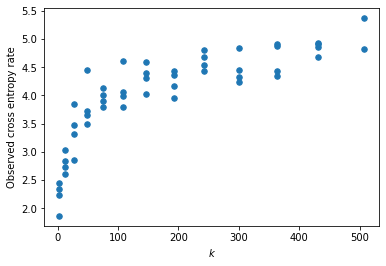

In [16]:
# Top-k scatter plot
import numpy as np
import matplotlib.pyplot as plt

sur_fig_k = plt.figure()
x = k_list
y = list_plot_surprise_k

#save plot data
x_k_list = np.array(x)
np.save('x_k_list', x_k_list)
plot_surprise_k = np.array(y)
np.save('plot_surprise_k', plot_surprise_k)

sizes = 30

plt.scatter(x, y, s=sizes, cmap='viridis')
plt.xlabel("$k$")
plt.ylabel("Observed cross entropy rate")
sur_fig_k.savefig('surprise_figure_k.eps', format='eps', dpi=1000)

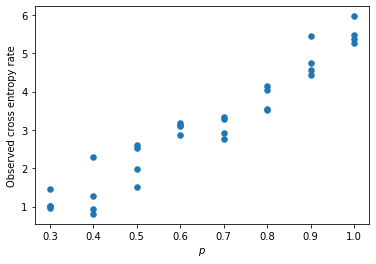

In [17]:
# Top-p scatter plot
import numpy as np
import matplotlib.pyplot as plt

sur_fig_p = plt.figure()
x = p_list 
y = list_plot_surprise_p 

#save plot data
x_p_list = np.array(x)
np.save('x_p_list',x_p_list)
plot_surprise_p = np.array(y)
np.save('plot_surprise_p',plot_surprise_p)

sizes = 30

plt.scatter(x, y, s=sizes, cmap='viridis')
plt.xlabel("$p$")
plt.ylabel("Observed cross entropy rate")
sur_fig_p.savefig('surprise_figure_p.eps', format='eps', dpi=1000)

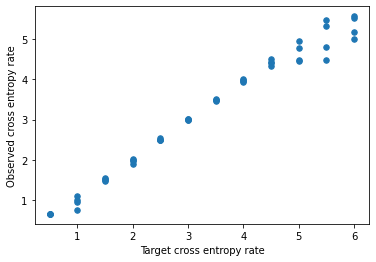

In [18]:
# Controlled surprise scatter plot
import numpy as np
import matplotlib.pyplot as plt

sur_fig_t = plt.figure()
x = t_list 
y = list_plot_surprise_t 

#save plot data
x_t_list = np.array(x)
np.save('x_t_list',x_t_list)
plot_surprise_t = np.array(list_plot_surprise_t)
np.save('plot_surprise_t',plot_surprise_t)

sizes = 30

plt.scatter(x, y, s=sizes, cmap='viridis')
plt.xlabel("Target cross entropy rate")
plt.ylabel("Observed cross entropy rate")
sur_fig_t.savefig('surprise_figure_t.eps', format='eps', dpi=1000)

###  5.2  PERPLEXITY AND REPETITION

#### Text decoding for repetitions

##### Top-k sampling

In [3]:
# Top-k decoding for repetition analysis
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math
import numpy as np

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')
temperature = 1
top_k_list = [round(2**(i/2)) for i in range(20)]
num_tokens = 200

c_entropy_top_k_list = []
repetition_top_k_list = []
repetition_top_k_list_2 = []
repetition_top_k_list_4 = []
repetition_top_k_list_6 = []
repetition_top_k_list_8 = []
repetition_top_k_list_10 = []
repetition_top_k_list_20 = []
sample_entropy_top_k_list = []


####################################################################
model.eval()
# If you have a GPU, put everything on cuda
# context = context.to('cuda')
# model.to('cuda')

num_samples = 10

with torch.no_grad():

  for top_k in top_k_list:
    print("k:", top_k)
    indices_error_list = []
    indices_surprise = []
    running_tot_surprise = 0
    list_avg_surprise = []
    generated = tokenizer.encode("For two months early in 1943, Shannon came into contact with the leading British mathematician Alan Turing. Turing had been posted to Washington to share with the U.S. Navy's cryptanalytic service the methods used by the British Government Code and Cypher School at Bletchley Park to break the ciphers used by the Kriegsmarine U-boats in the north Atlantic Ocean. He was also interested in the encipherment of speech and to this end spent time at Bell Labs.")
    context = torch.tensor([generated])
    generated = []
    prev = context
    past = None
    #context = context.to('cuda')
    #model.to('cuda')
    indices_error_list = []
    indices_surprise = []
    running_tot_surprise = 0
    list_avg_surprise = []
    for i in range(num_tokens):
      forward = model(input_ids=context, past_key_values=past, return_dict=True)
      logits = forward.logits[0, -1, :]
      past = forward.past_key_values
      sorted_logits, sorted_indices = torch.sort(logits, descending=True)
      prob_sorted_original = torch.softmax(sorted_logits, dim = 0).tolist()
      cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

      sorted_logits = sorted_logits[0:top_k]
      prob_sorted = torch.softmax(sorted_logits, dim = 0)
      prob_sorted_list = prob_sorted.tolist()
      prev_i = torch.multinomial(prob_sorted, num_samples=1, replacement=True)
      indices_surprise.append(math.log2(1/prob_sorted_original[prev_i]))
      indices_error_list.append(prev_i)
      prev = sorted_indices[prev_i]
      running_tot_surprise += math.log2(1/prob_sorted_original[prev_i])
      list_avg_surprise.append(running_tot_surprise/(i+1))
      generated += prev.tolist()
      context = torch.tensor([prev.tolist()])#.to('cuda')
    print("Total surprise value:", sum(indices_surprise))
    print("Average surprise value:", sum(indices_surprise)/num_tokens)
    print("Repetition percentage:",rep_percentage(generated))
    print("Repetition percentage 2-gram:",rep_percentage_n_gram(generated,2))
    print("Repetition percentage 4-gram:",rep_percentage_n_gram(generated,4))
    print("Repetition percentage 6-gram:",rep_percentage_n_gram(generated,6))
    print("Repetition percentage 8-gram:",rep_percentage_n_gram(generated,8))
    print("Repetition percentage 10-gram:",rep_percentage_n_gram(generated,10))
    print("Sample entropy:",sample_entropy(generated))
    #print(tokenizer.decode(generated))
    c_entropy_top_k_list.append(sum(indices_surprise)/num_tokens)
    repetition_top_k_list.append(rep_percentage(generated))
    repetition_top_k_list_2.append(rep_percentage_n_gram(generated,2))
    repetition_top_k_list_4.append(rep_percentage_n_gram(generated,4))
    repetition_top_k_list_6.append(rep_percentage_n_gram(generated,6))
    repetition_top_k_list_8.append(rep_percentage_n_gram(generated,8))
    repetition_top_k_list_10.append(rep_percentage_n_gram(generated,10))
    sample_entropy_top_k_list.append(sample_entropy(generated))
np.save("top_k_list",top_k_list)
np.save("c_entropy_top_k_list",c_entropy_top_k_list)
np.save("repetition_top_k_list",repetition_top_k_list)
np.save("repetition_top_k_list_2",repetition_top_k_list_2)
np.save("repetition_top_k_list_4",repetition_top_k_list_4)
np.save("repetition_top_k_list_6",repetition_top_k_list_6)
np.save("repetition_top_k_list_8",repetition_top_k_list_8)
np.save("repetition_top_k_list_10",repetition_top_k_list_10)
np.save("sample_entropy_top_k_list",sample_entropy_top_k_list)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

k: 1
Total surprise value: 136.72326844996516
Average surprise value: 0.6836163422498258
Repetition percentage: 85.0
Repetition percentage 2-gram: 76.88442211055276
Repetition percentage 4-gram: 67.00507614213198
Repetition percentage 6-gram: 60.51282051282051
Repetition percentage 8-gram: 54.92227979274612
Repetition percentage 10-gram: 51.30890052356021
Sample entropy: 0.022461328070765223
k: 1
Total surprise value: 136.72326844996516
Average surprise value: 0.6836163422498258
Repetition percentage: 85.0
Repetition percentage 2-gram: 76.88442211055276
Repetition percentage 4-gram: 67.00507614213198
Repetition percentage 6-gram: 60.51282051282051
Repetition percentage 8-gram: 54.92227979274612
Repetition percentage 10-gram: 51.30890052356021
Sample entropy: 0.022461328070765223
k: 2
Total surprise value: 361.41663075156913
Average surprise value: 1.8070831537578456
Repetition percentage: 64.5
Repetition percentage 2-gram: 38.19095477386934
Repetition percentage 4-gram: 23.857868020304

##### Top-p (nucleus) sampling

In [4]:
# Top-p decoding for repetition analysis
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math
import numpy as np

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')
temperature = 1
top_p_list = [0.05*(i+1) for i in range(20)]
num_tokens = 200
c_entropy_top_p_list = []
repetition_top_p_list = []
repetition_top_p_list_2 = []
repetition_top_p_list_4 = []
repetition_top_p_list_6 = []
repetition_top_p_list_8 = []
repetition_top_p_list_10 = []
repetition_top_p_list_20 = []
sample_entropy_top_p_list = []


####################################################################
model.eval()
#If you have a GPU, put everything on cuda
#context = context.to('cuda')
#model.to('cuda')

num_samples = 10

with torch.no_grad():

  for top_p in top_p_list:
    print("p:", top_p)
    indices_error_list = []
    indices_surprise = []
    running_tot_surprise = 0
    list_avg_surprise = []
    generated = tokenizer.encode("For two months early in 1943, Shannon came into contact with the leading British mathematician Alan Turing. Turing had been posted to Washington to share with the U.S. Navy's cryptanalytic service the methods used by the British Government Code and Cypher School at Bletchley Park to break the ciphers used by the Kriegsmarine U-boats in the north Atlantic Ocean. He was also interested in the encipherment of speech and to this end spent time at Bell Labs.")
    context = torch.tensor([generated])
    generated = []
    prev = context
    past = None
    #context = context.to('cuda')
    #model.to('cuda')
    indices_error_list = []
    indices_surprise = []
    running_tot_surprise = 0
    list_avg_surprise = []
    for i in range(num_tokens):
      forward = model(input_ids=context, past_key_values=past, return_dict=True)
      logits = forward.logits[0, -1, :]
      past = forward.past_key_values
      sorted_logits, sorted_indices = torch.sort(logits, descending=True)
      prob_sorted_original = torch.softmax(sorted_logits, dim = 0).tolist()
      cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

      if sorted_indices[cumulative_probs <= top_p].size()[0]>0:
        sorted_indices = sorted_indices[cumulative_probs <= top_p]
        sorted_logits = sorted_logits[cumulative_probs <= top_p]
      else:
        sorted_indices = sorted_indices[0:1]
        sorted_logits = sorted_logits[0:1]

      prob_sorted = torch.softmax(sorted_logits, dim = 0)
      prob_sorted_list = prob_sorted.tolist()
      prev_i = torch.multinomial(prob_sorted, num_samples=1, replacement=True)
      indices_surprise.append(math.log2(1/prob_sorted_original[prev_i]))
      indices_error_list.append(prev_i)
      prev = sorted_indices[prev_i]
      running_tot_surprise += math.log2(1/prob_sorted_original[prev_i])
      list_avg_surprise.append(running_tot_surprise/(i+1))
      generated += prev.tolist()
      context = torch.tensor([prev.tolist()])#.to('cuda')
    print("Total surprise value:", sum(indices_surprise))
    print("Average surprise value:", sum(indices_surprise)/num_tokens)
    print("Repetition percentage:",rep_percentage(generated))
    print("Repetition percentage 2-gram:",rep_percentage_n_gram(generated,2))
    print("Repetition percentage 4-gram:",rep_percentage_n_gram(generated,4))
    print("Repetition percentage 6-gram:",rep_percentage_n_gram(generated,6))
    print("Repetition percentage 8-gram:",rep_percentage_n_gram(generated,8))
    print("Repetition percentage 10-gram:",rep_percentage_n_gram(generated,10))
    print("Sample entropy:",sample_entropy(generated))
    # print(tokenizer.decode(generated))
    c_entropy_top_p_list.append(sum(indices_surprise)/num_tokens)
    repetition_top_p_list.append(rep_percentage(generated))
    repetition_top_p_list_2.append(rep_percentage_n_gram(generated,2))
    repetition_top_p_list_4.append(rep_percentage_n_gram(generated,4))
    repetition_top_p_list_6.append(rep_percentage_n_gram(generated,6))
    repetition_top_p_list_8.append(rep_percentage_n_gram(generated,8))
    repetition_top_p_list_10.append(rep_percentage_n_gram(generated,10))
    sample_entropy_top_p_list.append(sample_entropy(generated))
np.save("top_p_list",top_p_list)
np.save("c_entropy_top_p_list",c_entropy_top_p_list)
np.save("repetition_top_p_list",repetition_top_p_list)
np.save("repetition_top_p_list_2",repetition_top_p_list_2)
np.save("repetition_top_p_list_4",repetition_top_p_list_4)
np.save("repetition_top_p_list_6",repetition_top_p_list_6)
np.save("repetition_top_p_list_8",repetition_top_p_list_8)
np.save("repetition_top_p_list_10",repetition_top_p_list_10)
np.save("sample_entropy_top_p_list",sample_entropy_top_p_list)

p: 0.05
Total surprise value: 136.72326844996516
Average surprise value: 0.6836163422498258
Repetition percentage: 85.0
Repetition percentage 2-gram: 76.88442211055276
Repetition percentage 4-gram: 67.00507614213198
Repetition percentage 6-gram: 60.51282051282051
Repetition percentage 8-gram: 54.92227979274612
Repetition percentage 10-gram: 51.30890052356021
Sample entropy: 0.022461328070765223
p: 0.1
Total surprise value: 132.49893869181273
Average surprise value: 0.6624946934590636
Repetition percentage: 84.5
Repetition percentage 2-gram: 77.8894472361809
Repetition percentage 4-gram: 70.05076142131979
Repetition percentage 6-gram: 65.12820512820512
Repetition percentage 8-gram: 60.62176165803109
Repetition percentage 10-gram: 57.068062827225134
Sample entropy: 0.0226227430393245
p: 0.15000000000000002
Total surprise value: 80.47554876308018
Average surprise value: 0.4023777438154009
Repetition percentage: 89.0
Repetition percentage 2-gram: 85.42713567839196
Repetition percentage 4-g

##### Mirostat sampling

In [5]:
# Mirostat sampling repetition analysis
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math
import numpy as np

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')
temperature = 1
top_p = 1
num_trials = 10
target_surprise_list = [i/5+1 for i in range(20)]
num_tokens = 200
n=50257
c_entropy_miro_list = []
repetition_miro_list = []
repetition_miro_list_2 = []
repetition_miro_list_4 = []
repetition_miro_list_6 = []
repetition_miro_list_8 = []
repetition_miro_list_10 = []
repetition_miro_list_20 = []
sample_entropy_miro_list = []

####################################################################
model.eval()


# If you have a GPU, put everything on cuda
# context = context.to('cuda')
# model.to('cuda')

with torch.no_grad():

  for target_surprise in target_surprise_list:
    print("Target surprise:",target_surprise)
    generated = tokenizer.encode("For two months early in 1943, Shannon came into contact with the leading British mathematician Alan Turing. Turing had been posted to Washington to share with the U.S. Navy's cryptanalytic service the methods used by the British Government Code and Cypher School at Bletchley Park to break the ciphers used by the Kriegsmarine U-boats in the north Atlantic Ocean. He was also interested in the encipherment of speech and to this end spent time at Bell Labs.")
    context = torch.tensor([generated])
    generated = []
    prev = context
    past = None
    k = 10
    indices_error_list = []
    indices_surprise = []
    indices_entropy = []
    running_tot_surprise = 0
    list_s = []
    list_k = []
    max_surprise = 1.7*target_surprise
    error_surprise = 0
    learning_rate = 1

    for i in range(num_tokens):
      forward = model(input_ids=context, past_key_values=past, return_dict=True)
      logits = forward.logits[0, -1, :]
      past = forward.past_key_values
      sorted_logits, sorted_indices = torch.sort(logits, 0, descending=True)
      prob_list = torch.softmax(sorted_logits, dim=-1).tolist()

      # Estimate s
      s = estimate_s(prob_list[0:100])

      # Compute k
      k = max(compute_k(n,s,max_surprise),1)

      sorted_logits = sorted_logits[0:k]
      sorted_indices = sorted_indices[0:k]

      prob_sorted = torch.softmax(sorted_logits, dim = 0)
      prev_i = torch.multinomial(prob_sorted, num_samples=1, replacement=True)
      indices_surprise.append(math.log2(1/prob_list[prev_i]))
      indices_entropy.append(math.log2(1/prob_sorted[prev_i]))

      indices_error_list.append(prev_i)
      running_tot_surprise += math.log2(1/prob_list[prev_i])
      prev = sorted_indices[prev_i]
      generated += prev.tolist()
      context = torch.tensor([prev.tolist()])#.to('cuda')

      # Surprise control
      # window average
      window_len = 1  # keep window_len = 1 for Mirostat sampling
      if i>window_len-1:
        window_size = window_len
      else:
        window_size = i+1
      window_surprise = sum(indices_surprise[i-window_size+1:i+window_size])/window_size
      #adjust max_surprise
      error_surprise = window_surprise - target_surprise
      #print(max_surprise, window_surprise, error_surprise)
      max_surprise -= 1*error_surprise
      max_surprise = max(max_surprise,0)
    print("Total surprise value:", sum(indices_surprise))
    print("Average surprise value:", sum(indices_surprise)/num_tokens)
    print("Entropy:", sum(indices_entropy)/num_tokens)
    print("Repetition percentage:",rep_percentage(generated))
    print("Repetition percentage 2:",rep_percentage_n_gram(generated,2))
    print("Repetition percentage 4:",rep_percentage_n_gram(generated,4))
    print("Repetition percentage 6:",rep_percentage_n_gram(generated,6))
    print("Repetition percentage 8:",rep_percentage_n_gram(generated,8))
    print("Repetition percentage 10:",rep_percentage_n_gram(generated,10))
    print(tokenizer.decode(generated))
    print("Sample entropy:",sample_entropy(generated))
    #print(tokenizer.decode(generated))
    c_entropy_miro_list.append(sum(indices_surprise)/num_tokens)
    repetition_miro_list.append(rep_percentage(generated))
    repetition_miro_list_2.append(rep_percentage_n_gram(generated,2))
    repetition_miro_list_4.append(rep_percentage_n_gram(generated,4))
    repetition_miro_list_6.append(rep_percentage_n_gram(generated,6))
    repetition_miro_list_8.append(rep_percentage_n_gram(generated,8))
    repetition_miro_list_10.append(rep_percentage_n_gram(generated,10))
    sample_entropy_miro_list.append(sample_entropy(generated))
np.save("miro_list",target_surprise_list)
np.save("c_entropy_miro_list",c_entropy_miro_list)
np.save("repetition_miro_list",repetition_miro_list)
np.save("repetition_miro_list_2",repetition_miro_list_2)
np.save("repetition_miro_list_4",repetition_miro_list_4)
np.save("repetition_miro_list_6",repetition_miro_list_6)
np.save("repetition_miro_list_8",repetition_miro_list_8)
np.save("repetition_miro_list_10",repetition_miro_list_10)
np.save("sample_entropy_miro_list",sample_entropy_miro_list)

Target surprise: 1.0
Total surprise value: 232.0552154718119
Average surprise value: 1.1602760773590595
Entropy: 0.51304585703696
Repetition percentage: 78.0
Repetition percentage 2: 69.34673366834171
Repetition percentage 4: 57.868020304568525
Repetition percentage 6: 48.205128205128204
Repetition percentage 8: 39.37823834196891
Repetition percentage 10: 31.413612565445025


In April 1943, Shannon was assigned to the U.S. Navy's Cryptanalytic Service. He was assigned to the cryptanalytical unit of the U.S. Navy's Cryptanalytic Service.

In May 1943, Shannon was assigned to the cryptanalytic unit of the U.S. Navy's Cryptanalytic Service. He was assigned to the cryptanalytic unit of the U.S. Navy's Cryptanalytic Service. Another part of her job had been to work on the cryptanalytic unit of the U.S. Navy's Cryptanalytical Service.

In late May 1943, Shannon was assigned to the cryptanalytical unit of the U.S. Navy's Cryptanalytic Service. Because of this assignment, she worked on the cry

#### Repetition plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


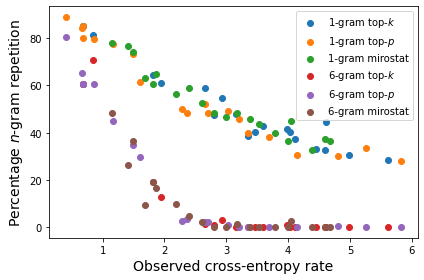

In [6]:
# Mirostat Repetition vs. cross entropy for top-p sampling with different n-grams
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()

x_k = np.load('c_entropy_top_k_list.npy')
x_p = np.load('c_entropy_top_p_list.npy')
x_miro = np.load('c_entropy_miro_list.npy')

y_1_k = np.load('repetition_top_k_list.npy')
y_1_p = np.load('repetition_top_p_list.npy')
y_1_miro = np.load('repetition_miro_list.npy')
y_6_k = np.load('repetition_top_k_list_6.npy')
y_6_p = np.load('repetition_top_p_list_6.npy')
y_6_miro = np.load('repetition_miro_list_6.npy')

plt.xlabel("Observed cross-entropy rate", fontsize=14)
plt.ylabel("Percentage $n$-gram repetition", fontsize=14)

plt.scatter(x_k,y_1_k,label="1-gram top-$k$")
plt.scatter(x_p,y_1_p,label="1-gram top-$p$")
plt.scatter(x_miro,y_1_miro,label="1-gram mirostat")

plt.scatter(x_k,y_6_k,label="6-gram top-$k$")
plt.scatter(x_p,y_6_p,label="6-gram top-$p$")
plt.scatter(x_miro,y_6_miro,label="6-gram mirostat")

plt.legend()
plt.tight_layout()
fig.savefig('repetition_experiment_n_gram_all.eps', format='eps', dpi=1000)